In [2]:
pip install pandas Sastrawi emoji swifter pandarallel

  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16674 sha256=c71c4d480a5ce4b765eb6cbdb986672e18f301821d8304106c577ae888010b71
  Stored in directory: /root/.cache/pip/wheels/46/f9/0d/40c9cd74a7cb8dc8fe57e8d6c3c19e2c730449c0d3f2bf66b5
Successfully built pandarallel


In [3]:
import pandas as pd
import re
import string
import emoji
import torch
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from pandarallel import pandarallel

df = pd.read_csv('/content/drive/MyDrive/Dataset purbaya seri/hasil_labelling_final_filtered.csv')
df

,text,tokoh,prediksi_label_raw,score_keyakinan,label_final
0,Pembantu mu banyak yg rusak paak,Purbaya Yudhi Sadewa,negative,0.999369,Negatif
1,Ia pa benar pasl 33 skarang pengusaha suasta s...,Purbaya Yudhi Sadewa,negative,0.999472,Negatif
2,"Jangan Angguk angguk aja, Mentri Kehutanan,Lih...",Purbaya Yudhi Sadewa,negative,0.999365,Negatif
3,Susah di pecat kalau menterinya ketum parpol,Purbaya Yudhi Sadewa,negative,0.996516,Negatif
4,Kerusakan lingkungan tidak akan terjadi kalau ...,Purbaya Yudhi Sadewa,negative,0.999033,Negatif
...,...,...,...,...,...
9790,RUANG FISKAL TIDAK ADA KRN PEMERINTAH SUDAH BE...,Sri Mulyani Indrawati,negative,0.992726,Negatif
9791,"Bubarkan DPR sd korupsi mkn gaji buta lagi, sa...",Sri Mulyani Indrawati,negative,0.998874,Negatif
9792,Kalau memang uang negara belum cukup tuk ASN k...,Sri Mulyani Indrawati,negative,0.928499,Negatif
9793,"Prabowo mengutamakan para pejabat,kasian pk,pr...",Sri Mulyani Indrawati,negative,0.997244,Negatif


In [4]:
# --- 1. CEK KETERSEDIAAN HARDWARE ---
# Inisialisasi Parallel Processing (Memanfaatkan semua Core CPU di Runtime GPU kamu)
pandarallel.initialize(progress_bar=True, nb_workers=4) # nb_workers menyesuaikan core CPU colab

# Cek apakah GPU terdeteksi (Untuk tahap training nanti)
if torch.cuda.is_available():
    print(f"✅ GPU Terdeteksi: {torch.cuda.get_device_name(0)}")
    print("GPU siap digunakan untuk tahap Vektorisasi/Training nanti.")
else:
    print("⚠️ GPU tidak terdeteksi. Pastikan Runtime Type -> GPU.")

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
✅ GPU Terdeteksi: Tesla T4
GPU siap digunakan untuk tahap Vektorisasi/Training nanti.


In [5]:
factory_stem = StemmerFactory()
stemmer = factory_stem.create_stemmer()

factory_sw = StopWordRemoverFactory()
stopwords_list = factory_sw.get_stop_words()

# 2. Setup Dictionary & Stopwords
normalisasi_dict = {
    "yg": "yang", "gk": "tidak", "gak": "tidak", "ga": "tidak",
    "kalo": "kalau", "klo": "kalau", "kyk": "kayak",
    "wkwk": "tertawa", "wkwkwk": "tertawa", "wk": "tertawa",
    "paak": "pak", "pa": "pak", "bpk": "bapak",
    "smisal": "semisal", "byak": "banyak", "dgn": "dengan",
    "sdh": "sudah", "aja": "saja", "bgt": "banget",
    "asikkk": "asik", "sip": "siap", "ok": "oke",
    "bahlul": "bodoh",
    "mentri": "menteri", "tri": "menteri",
    "lemot": "lambat", "lot": "lambat",
    "copot": "pecat", "suasta": "swasta",
    "pasl": "pasal", "menjawaydan": "menjawab dan"
}

# Hapus kata negasi dari stopwords agar tidak hilang
negation_words = {'tidak', 'tak', 'bukan', 'jangan', 'belum', 'ga', 'gak', 'gk', 'tdk', 'jgn'}

custom_stopwords_raw = [
    "dan", "yang", "di", "ke", "dari", "ini", "itu",
    "yg", "dg", "rt", "dgn", "ny", "d", "klo",
    "kalo", "amp", "biar", "bikin", "bilang",
    "krn", "nya", "nih", "sih",
    "si", "tau", "tdk", "tuh", "utk", "ya",
    "jd", "jgn", "sdh", "aja", "n", "t",
    "nyg", "hehe", "pen", "u", "nan", "loh", "rt"
]

final_stopwords = set(stopwords_list + custom_stopwords_raw) - negation_words

emoji_map = {
    "rolling on the floor laughing": "tertawa",
    "face with tears of joy": "tertawa",
    "loudly crying face": "menangis",
    "thumbs up": "oke",
    "clapping hands": "tepuk tangan",
    "person shrugging": "tidak tahu",
    "face with symbols on mouth": "marah",
    "angry face": "marah"
}

# --- FUNGSI 1: CLEANING DASAR (Tanpa Stemming) ---
def preprocess_basic(text):
    if not isinstance(text, str): return ""

    text = text.lower()

    # Emoji
    text = emoji.demojize(text, delimiters=(" ", " "))
    for eng_emoji, indo_word in emoji_map.items():
        text = text.replace(eng_emoji.replace(" ", "_"), indo_word)
    text = re.sub(r':[a-z_]+:', '', text)

    # Cleaning
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.replace('-', ' ')
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = text.strip()

    words = text.split()
    clean_words = []

    for word in words:
        if word in normalisasi_dict:
            word = normalisasi_dict[word]

        if word in final_stopwords:
            continue

        # Simpan kata > 1 huruf atau kata negasi
        if len(word) > 1 or word in negation_words:
            clean_words.append(word)

    return " ".join(clean_words)


In [6]:
# --- FUNGSI 2: TAMBAHAN STEMMING (Memanggil fungsi dasar dulu) ---
def preprocess_with_stemming(text):
    # Bersihkan dulu pakai fungsi di atas
    cleaned_text = preprocess_basic(text)

    words = cleaned_text.split()
    stemmed_words = []

    for word in words:
        # Pengecualian Stemming
        if word in ['menteri', 'presiden', 'rakyat', 'negara', 'pemerintah', 'jokowi', 'prabowo'] or word in negation_words:
            stemmed_words.append(word)
        else:
            stemmed_words.append(stemmer.stem(word))

    return " ".join(stemmed_words)

In [7]:
# --- EKSEKUSI ---
print("Memproses Tanpa Stemming...")
df['clean_no_stem'] = df['text'].parallel_apply(preprocess_basic)


Memproses Tanpa Stemming...


In [8]:
print("Memproses Dengan Stemming...")
df['clean_with_stem'] = df['text'].parallel_apply(preprocess_with_stemming)

Memproses Dengan Stemming...


In [9]:
print("\nPerbandingan:")
print(df[['text', 'clean_no_stem', 'clean_with_stem']].head(5))


Perbandingan:
                                                text  \
0                   Pembantu mu banyak yg rusak paak   
1  Ia pa benar pasl 33 skarang pengusaha suasta s...   
2  Jangan Angguk angguk aja, Mentri Kehutanan,Lih...   
3       Susah di pecat kalau menterinya ketum parpol   
4  Kerusakan lingkungan tidak akan terjadi kalau ...   

                                       clean_no_stem  \
0                       pembantu mu banyak rusak pak   
1  pak benar pasal skarang pengusaha swasta semis...   
2  jangan angguk angguk menteri kehutanan lihat r...   
3          susah pecat kalau menterinya ketum parpol   
4  kerusakan lingkungan tidak terjadi kalau peneg...   

                                     clean_with_stem  
0                          bantu mu banyak rusak pak  
1  pak benar pasal skarang usaha swasta misal pt ...  
2  jangan angguk angguk menteri hutan lihat rakya...  
3               susah pecat kalau menteri tum parpol  
4  rusa lingkung tidak jadi kalau te

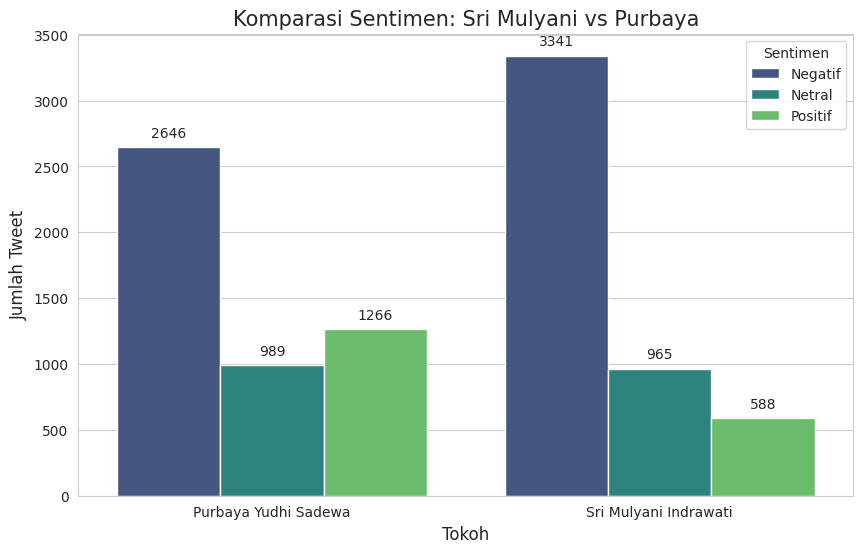

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Setting gaya visualisasi
sns.set_style("whitegrid")

# ==========================================
# 1. VISUALISASI JUMLAH SENTIMEN (Cukup 1 Grafik)
# ==========================================
# Ini tidak terpengaruh stemming karena pakai kolom 'label_final'
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='tokoh', hue='label_final', data=df, palette='viridis')

plt.title('Komparasi Sentimen: Sri Mulyani vs Purbaya', fontsize=15)
plt.xlabel('Tokoh', fontsize=12)
plt.ylabel('Jumlah Tweet', fontsize=12)
plt.legend(title='Sentimen')

# Menampilkan angka di atas batang
for p in ax.patches:
    if p.get_height() > 0: # Cek biar ga error kalau 0
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

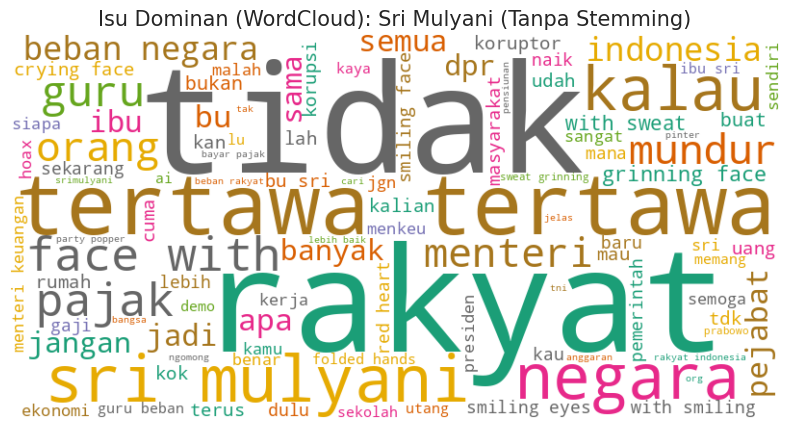

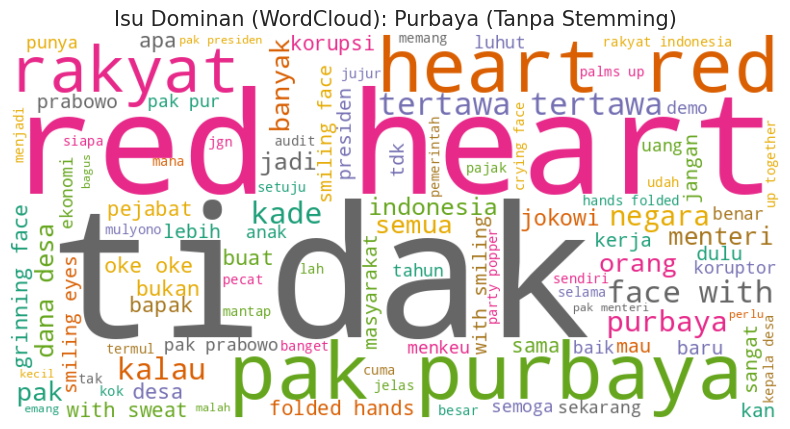

In [11]:
# ==========================================
# 2. WORDCLOUD (Gunakan clean_no_stem agar terbaca)
# ==========================================
def generate_wordcloud(nama_tokoh, title):
    # KITA PAKAI KOLOM 'clean_no_stem' AGAR TIDAK ADA KATA 'RUSA' (Kerusakan)
    text_data = df[df['tokoh'] == nama_tokoh]['clean_no_stem'].dropna().str.cat(sep=' ')

    # Custom stopwords tambahan untuk visualisasi jika ada kata sampah nyelip
    # Misal: kata 'yg' atau 'nya' masih bandel, masukkan sini
    stopwords_vis = {'yg', 'nya', 'dan', 'di'}

    wc = WordCloud(width=800, height=400, background_color ='white',
                   colormap='Dark2', max_words=100, stopwords=stopwords_vis).generate(text_data)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Isu Dominan (WordCloud): {title}', fontsize=15)
    plt.show()

# Generate untuk kedua tokoh
generate_wordcloud('Sri Mulyani Indrawati', 'Sri Mulyani (Tanpa Stemming)')
generate_wordcloud('Purbaya Yudhi Sadewa', 'Purbaya (Tanpa Stemming)')

/tmp/ipython-input-1881701625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='ngram', data=df_ngram.head(10), palette='magma')


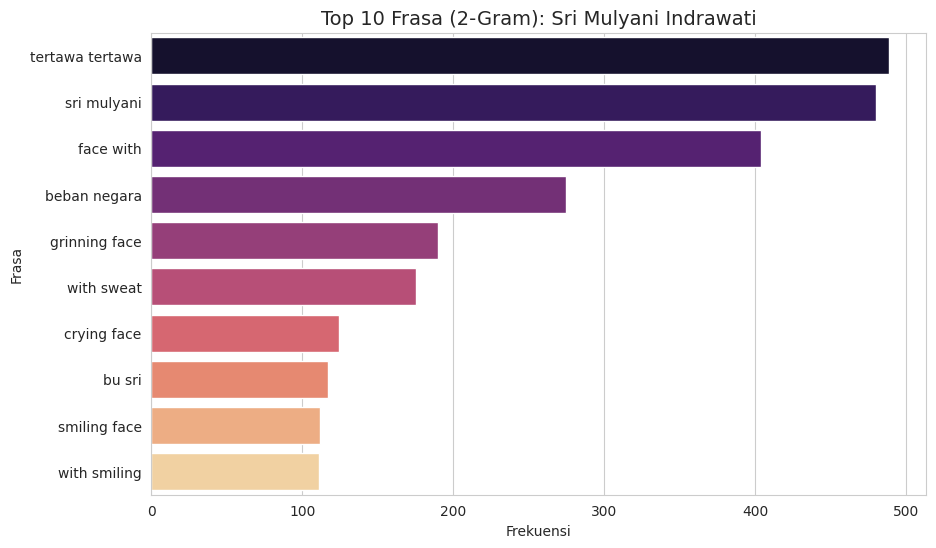

/tmp/ipython-input-1881701625.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='ngram', data=df_ngram.head(10), palette='magma')


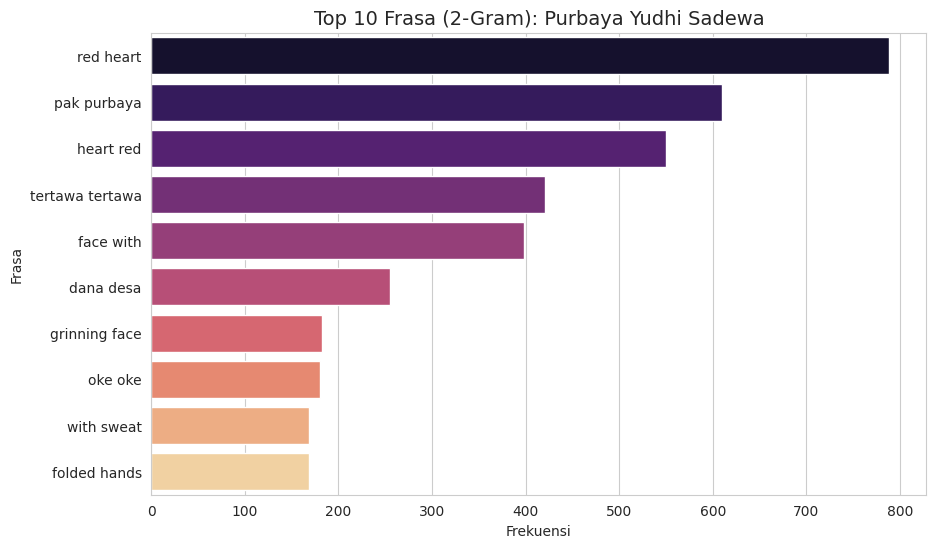

In [12]:
# ==========================================
# 3. N-GRAM (Bigram - 2 Kata)
# ==========================================
def plot_ngram(nama_tokoh, n=2):
    subset = df[df['tokoh'] == nama_tokoh]

    # PAKAI 'clean_no_stem' LAGI
    c_vec = CountVectorizer(ngram_range=(n, n))
    # Pastikan tidak ada nilai null
    text_input = subset['clean_no_stem'].dropna()

    if len(text_input) == 0:
        print(f"Data kosong untuk {nama_tokoh}")
        return

    ngrams = c_vec.fit_transform(text_input)
    count_values = ngrams.toarray().sum(axis=0)
    vocab = c_vec.vocabulary_

    df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True))
    df_ngram.columns = ['frequency', 'ngram']

    plt.figure(figsize=(10, 6))
    sns.barplot(x='frequency', y='ngram', data=df_ngram.head(10), palette='magma')
    plt.title(f'Top 10 Frasa ({n}-Gram): {nama_tokoh}', fontsize=14)
    plt.xlabel('Frekuensi')
    plt.ylabel('Frasa')
    plt.show()

# Tampilkan N-Gram
plot_ngram('Sri Mulyani Indrawati', n=2)
plot_ngram('Purbaya Yudhi Sadewa', n=2)